In [23]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import seaborn as sns
import torch as th
import matplotlib.pyplot as plt
from aimanager.utils.utils import make_dir, load_yaml
from aimanager.utils.array_to_df import using_multiindex, add_labels
from aimanager.utils.merge import merge_files_by_name

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

run = '13_hiddensize'

folder = f'../../data/manager_v3/{run}'

train_folder = os.path.join(folder, 'metrics')
merge_file = os.path.join(folder, 'metrics.parquet')
model_folder = os.path.join(folder, 'model')

plot_folder = f'plots/{run}'

make_dir(plot_folder)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
# if not os.path.isfile(merge_file):
#     dfs = [pd.read_parquet(os.path.join(train_folder, file)) for file in os.listdir(train_folder)]
#     df = pd.concat(dfs)
#     df.to_parquet(merge_file)
# else:
#     df = pd.read_parquet(merge_file)
dfs = [pd.read_parquet(os.path.join(train_folder, file)) for file in os.listdir(train_folder)]
df = pd.concat(dfs)

In [25]:
df.columns

Index(['hidden_size', 'run', 'job_id', 'round_number', 'sampling',
       'update_step', 'metric', 'value'],
      dtype='object')

In [26]:
non_labels = ['round_number', 'sampling', 'update_step', 'metric', 'value', 'job_id', 'run']

labels = [c for c in df.columns if c not in non_labels]


In [27]:
labels

['hidden_size']

In [28]:
import statsmodels.formula.api as smf
w = (
    (df['metric'] == 'common_good') &
    (df['sampling'] == 'greedy')
)
dfs = df[w].copy()
w_max = (dfs['update_step'] > (0.8 * dfs['update_step'].max()))
dfs = dfs[w_max].copy()

for l in labels:
    dfs[l] = dfs[l].astype(str)


label_ref = {
    'eps': '0.1',
    'gamma': '1.0',
    'lr': '3.e-4',
    'memory_episodes': '100',
    'target_update_freq': '200',
    'hidden_size': '5',
    'features': 'contributions'
}


label_str = [f"C({l}, Treatment(reference='{label_ref[l]}'))" if l in label_ref else l for l in labels]


results = smf.glm(f"value ~ {'+'.join(label_str)}", data=dfs).fit()
results_df = results.summary2().tables[1]
results_df

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,23.678077,0.040482,584.899444,0.000000e+00,23.598733,23.757421
"C(hidden_size, Treatment(reference='5'))[T.100]",1.036488,0.057251,18.104401,2.941924e-73,0.924279,1.148697
"C(hidden_size, Treatment(reference='5'))[T.20]",1.344610,0.057251,23.486386,5.619291e-122,1.232401,1.456819
"C(hidden_size, Treatment(reference='5'))[T.40]",0.987493,0.057251,17.248604,1.146356e-66,0.875284,1.099702


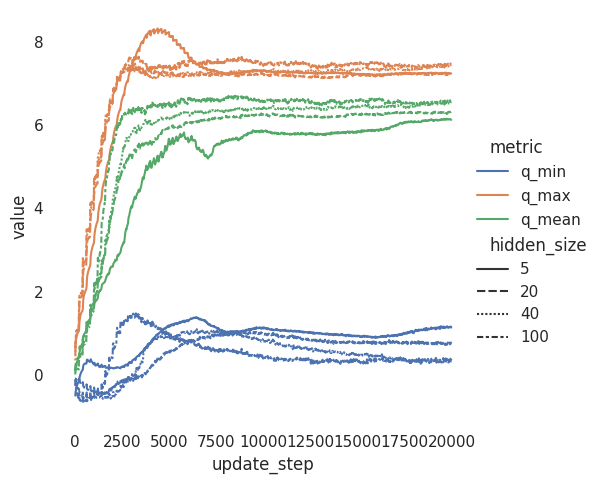

In [29]:
selection = {
    'eps': 0.2, 'gamma': 1, 'hidden_size': 20, 'lr': '3.e-4', 
    'memory_episodes': 100, 'sampling': 'greedy', 
    'target_update_freq': 200, 'features': 'contributions',
    'artificial_humans': 'complex'}

focus = ['update_step', 'metric', 'hidden_size']

# selection = {k: v for k, v in ref.items() if k != focus}

w = pd.concat(
    (df[k] == v
    for k,v in selection.items() if (k not in focus) and (k in df.columns)
    ), axis=1
).all(1)
dfs = df[w].reset_index(drop=True).copy()

w = dfs['metric'].isin(['q_min', 'q_max', 'q_mean'])
dfs = dfs[w]


fg = sns.relplot(
    data=dfs, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    style=focus[2] if len(focus) >= 3 else None,
    col=focus[3] if len(focus) >= 4 else None, 
    row=focus[4] if len(focus) >= 5 else None, 
    kind='line', ci=None)


fg.savefig(os.path.join(plot_folder, 'q_values.jpg'))

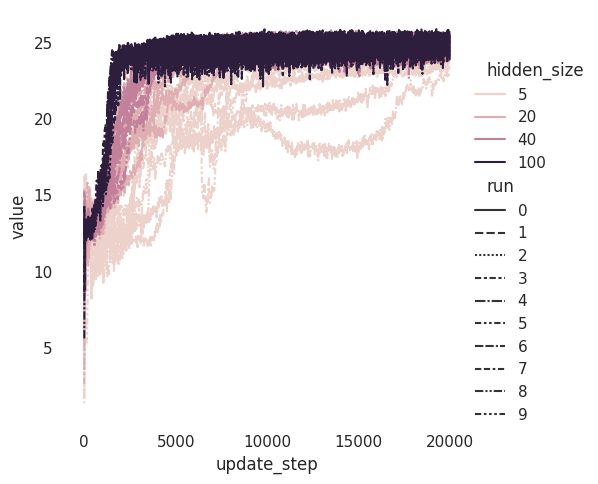

In [30]:
focus = ['update_step', 'hidden_size', 'run']

w = pd.concat(
    (df[k] == v
    for k,v in selection.items() if (k not in focus) and (k in df.columns)
    ), axis=1
).all(1)
dfs = df[w].reset_index(drop=True).copy()

w = dfs['metric'].isin(['common_good'])
dfs = dfs[w]


fg = sns.relplot(
    data=dfs, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    style=focus[2] if len(focus) >= 3 else None,
    col=focus[3] if len(focus) >= 4 else None, 
    row=focus[4] if len(focus) >= 5 else None, 
    kind='line', ci=None)


fg.savefig(os.path.join(plot_folder, 'q_values.jpg'))

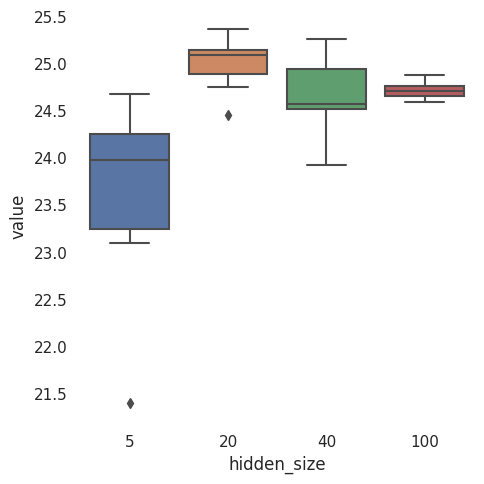

In [31]:
focus = ['hidden_size']

w = pd.concat(
    (df[k] == v
    for k,v in selection.items() if (k not in focus) and (k in df.columns)
    ), axis=1
).all(1)
dfs = df[w].reset_index(drop=True).copy()

w = dfs['metric'].isin(['common_good'])
dfs = dfs[w]

w_max = (dfs['update_step'] > (0.8 * dfs['update_step'].max()))
dfs = dfs[w_max].copy()

dfs = dfs.groupby(labels + ['run'])['value'].mean().reset_index()

fg = sns.catplot(
    data=dfs, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    col=focus[2] if len(focus) >= 3 else None, 
    row=focus[3] if len(focus) >= 4 else None, 
    kind='box')